Mounting your GoogleDrive

(GoogleDrive authorization will be asked)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis'

Mounted at /content/drive


NOTE: In the below Set-up section, adjust relevant file paths so that they will fit your directory structure.

---
# **Set-up**

In [2]:
RW_engine = 'pyogrio'
rasterSwitch = 'NO'

Importing module(s)

In [4]:
!pip install geopandas rioxarray richdem geemap rasterio import_ipynb pyshp pycrs pyogrio xarray-spatial tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.3 MB/s eta 0:00:00
 

In [5]:
# Colab default packages
import io
import os
import types
import sys
import glob
import importlib
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import pandas as pd
import json
import datetime
from sklearn.neighbors import KDTree
from shapely.geometry import mapping
from shapely import geometry
from shapely.validation import make_valid
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import metrics

# Temporarily installed packages
import geopandas as gpd
import xarray as xr
from xrspatial import zonal_stats
import rioxarray
import rasterio
from rasterio import features
import richdem as rd
import geemap
import pyogrio
import pycrs
import import_ipynb
from matplotlib.ticker import ScalarFormatter

# Import external files
os.chdir(program_location)
!pwd

sys.path.append(program_location)

import tools
importlib.reload(tools)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/tools.py'>

Generating an 'output' foldirectory in the target city directory

Adjust file path as you want.

In [6]:
data_loc = os.path.join(os.getcwd(), 'data')
output_loc = os.path.join(data_loc, 'output')
fig_loc = os.path.join(os.getcwd(), 'figs')


print(data_loc)
print(fig_loc)
print(output_loc)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/figs
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output


In [7]:
if not os.path.exists(output_loc):
    os.mkdir(output_loc)

---
# **Construct an Xarray dataset**

Convert all pre-downloaded VIIRS geotiff files to a single X-array dataset. This is a memory-heavy process. Need at least +50 GB RAM.

Here, you can select only OPTION-1 or OPTION-2. Both options cannot work at the same time. You need to reset the runtime if you want to work with another option.

## OPTION-1 VIIRS version (priority, monthly 2014-2024)

In [35]:
# Read the downloaded VIIRS rasters form local disk (check the data location specified by 'data_loc')
list_rasters = sorted( glob.glob(os.path.join(data_loc, 'output', 'viirs', '*.tif')) )
list_time = []

# Define the date range so that you don't need to import the whole rasters each time
import datetime
start_date = datetime.datetime.strptime("2014-01-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2024-03-01", "%Y-%m-%d")

# Filter the list to keep only files within the date range
filtered_rasters = []
for x in list_rasters:
    # Extract the date part from the filename (assuming format like 'afg_viirs_YYYYMM.tif')
    filename = os.path.basename(x)
    file_date_str = filename.split('_')[2].split('.')[0]
    file_date = datetime.datetime.strptime(file_date_str, "%Y%m")

    # Check if the file's date is within the specified range
    if start_date <= file_date <= end_date:
        filtered_rasters.append(x)
        list_time.append(file_date)



#assign the filtered rasters_rasters to list_rasters
list_rasters = filtered_rasters

# Print the filtered list of rasters
for raster in filtered_rasters:
    print(raster)

# Construct time coordinate

# Convert the time list to a time array
time = np.array(list_time)
time_var = xr.Variable('time', time)

# Construct VIIRS data array
da = xr.concat([rioxarray.open_rasterio(i) for i in list_rasters], dim = time_var)

# Convert the DA to a xarray dataset
ds = da.to_dataset("band")
ds = ds.rename({1: 'avg_rad'})

print(ds)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201401.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201402.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201403.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201404.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201405.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201406.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201407.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201408.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201409.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirs/afg_viirs_201410.tif
/content/drive/MyDrive/Colab N

In [36]:
# Compute basic statistics
ds['sum'] = ds.avg_rad.sum(["x", "y"])
ds['sum_LOG'] = np.log(ds.avg_rad.sum(["x", "y"]))

# STD has already been calcualted and the polygons are available in the data
#ds['std'] = ds.avg_rad.std(dim = 'time')

In [37]:
#ds['std'].plot()


## OPTION-2 VIIRS-like version (if you need extended time-series. 2000-2022, Only yearly)

In [38]:
# Read the downloaded VIIRS-like rasters form local disk (check the data location specified by 'data_loc')
# This is optional, either run OPTION-1 or OPTION-2

list_rasters = sorted( glob.glob(os.path.join(data_loc, 'output', 'viirsLike_yearly', '*.tif')) )
list_time = []

# Define the date range so that you don't need to import the whole rasters each time
import datetime
start_year = 1980
end_year = 2024

# Filter the list to keep only files within the date range
filtered_rasters = []
for x in list_rasters:
    # Extract the date part from the filename (assuming format like 'afg_viirs_YYYYMM.tif')
    filename = os.path.basename(x)
    file_year = filename.split('_')[2].split('.')[0]
    file_date = datetime.datetime.strptime(file_year, '%Y')

    # Check if the file's date is within the specified range
    if start_year <= int(file_year) <= end_year:
        filtered_rasters.append(x)
        list_time.append(file_date)

#assign the filtered rasters_rasters to list_rasters
list_rasters = filtered_rasters

# Print the filtered list of rasters
for raster in filtered_rasters:
    print(raster)


# Convert the time list to a time array
time = np.array(list_time)
time_var = xr.Variable('time', time)



# Construct VIIRS data array
da = xr.concat([rioxarray.open_rasterio(i) for i in list_rasters], dim = time_var)


# Convert the DA to a xarray dataset
ds = da.to_dataset("band")
ds = ds.rename({1: 'avg_rad'})

ds

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2000.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2001.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2002.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2003.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2004.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2005.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2006.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2007.tif
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output/viirsLike_yearly/AFG_viirsLike_2008.tif
/content/d

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 23, y: 2188, x: 3460)
Coordinates:
  * x            (x) float64 28kB 60.48 60.48 60.49 60.49 ... 74.88 74.89 74.89
  * y            (y) float64 18kB 38.49 38.49 38.48 38.48 ... 29.39 29.38 29.38
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 184B 2000-01-01 2001-01-01 ... 2022-01-01
Data variables:
    avg_rad      (time, y, x) float64 1GB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  0.01343894118908271
    STATISTICS_MAXIMUM:      43.101516723633
    STATISTICS_MEAN:         0.0014013023804154
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.11592644732365
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               b1

In [39]:
# Compute basic statistics
ds['sum'] = ds.avg_rad.where(ds['avg_rad'] < 300).sum(["x", "y"])
ds['sum_LOG'] = np.log(ds.avg_rad.sum(["x", "y"]))
ds['std'] = ds.avg_rad.std(dim = 'time')

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


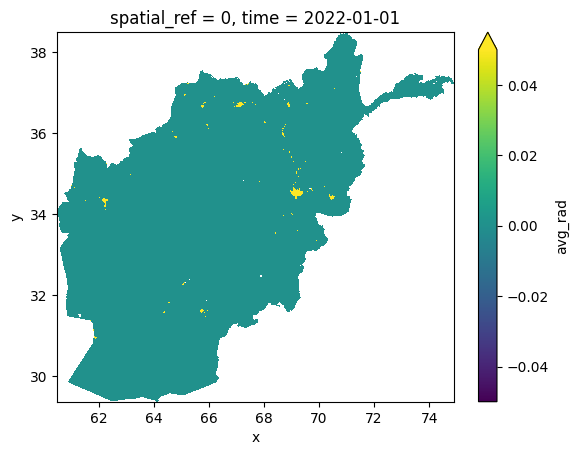

In [27]:
# Spatially visualize one of the avg_rad
sample_time = '2022-01-01'

ds['avg_rad'].sel(time = sample_time).plot(robust = True)

---
# **Filter-1: Noise reduction (background and max anomalies)**

**For the VIIRS-like data**, you must skip this section as it is already background noise reduced.

In [44]:
# Import annual mask created by Earth Observation Group, Payne Institute for Public Policy, Colorado School of Mines
src_ras = os.path.join(data_loc, 'output', 'ABCs', 'afg_viirs_ABC_2014_2021.tif')
mask_v21 = rioxarray.open_rasterio(src_ras)


# Here band is 'average_masked' that is extracted in the downloading process
ds_mask = mask_v21.to_dataset("band")
ds_mask = ds_mask.rename({1: 'mask'})

ds_mask['mask_bool'] = ds_mask['mask'] > 0


# Applying background noise and max anomaly filters to 'avg_rad' variable
# Here the max anomaly filter is set to avg_rad < 300

ds['avg_rad_BNR'] = ds['avg_rad'].where(ds_mask['mask_bool'] & (ds['avg_rad'] < 300) & (ds['avg_rad'] > 0))

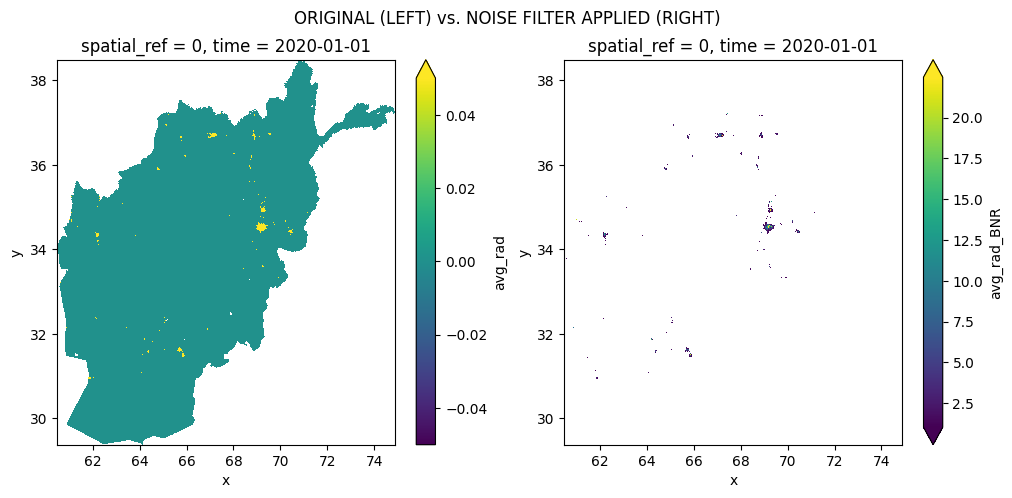

In [45]:
# Spatially visualize the filter effect (Right Panel)
sample_time = '2020-01-01'

if datetime.datetime.strptime(sample_time, '%Y-%m-%d') in list_time:
  fig = plt.figure(figsize = (12, 5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1 = ds['avg_rad'].sel(time = sample_time).plot(robust = True)

  ax2 = fig.add_subplot(1, 2, 2)
  ax2 = ds['avg_rad_BNR'].sel(time = sample_time).plot(robust = True)


  # Add fig title
  fig.suptitle("ORIGINAL (LEFT) vs. NOISE FILTER APPLIED (RIGHT)")

  plt.show()

  # Export fig (optional)
  #src_fig_temp = os.path.join(fig_loc, 'spatial_visualization_of_BNR_effect.png')
  #fig.savefig(src_fig_temp, bbox_inches="tight", dpi=500)
else:
  print(f"sample_time not present in raster list")
  print(list_time)

In [ ]:
# Export the raster that the noise reduction filter applied if needed (OPTIONAL)

# Want export? 'yes' or 'no'
export_option = 'yes'

if export_option == 'yes':

    for y in range(2014, 2024):

        for m in range(1, 13):
          time_temp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
          print(time_temp)

          # Construct a temporary file path
          out_ras_name = os.path.join(data_loc, 'output', 'NRA_afg_viirs_' + str(y) + str(m).zfill(2) + '01' + '.tif')


          # Export an x array
          ds['avg_rad_BNR'].sel(time = time_temp).rio.to_raster(out_ras_name)

---
# **Filter-2: OSM-Military filter**

### OSM-military polygon raster prep

First import the OSM military polygons

In [56]:
# Import
src_OSM_mBase = os.path.join(data_loc, 'OSM_military_base_ALL', 'OSM_military_base_ALL.shp')
gdf_OSM_mBase = tools.vec_import(RW_engine, src_OSM_mBase )

gdf_OSM_mBase['ID'] = gdf_OSM_mBase.index + 1


# Transform the CRS to that of DS
gdf_OSM_mBase.to_crs(ds.rio.crs, inplace = True)
gdf_OSM_mBase.crs

Vector import complete.
GDF size:558
EPSG:4326


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Rasterize the OSM polygons

In [57]:
# Rasterize the province geometry list
# You can select any template variable from DS, which must be 2 dimensional (x, y) without the time dimension.
# Here, we use the 'std' variable, which is a 2 dimensional variable.

r_base_ALL = features.rasterize(gdf_OSM_mBase['geometry'], out_shape = ds['std'].shape, transform = ds.rio.transform())


xr_baseALL = ds['std'].copy(deep = True) #copying the std values to the bases
xr_baseALL.data = r_base_ALL #setting the rasterized values to the bases

# Convert to a DS and boolean array
ds_baseALL = xr_baseALL.to_dataset()


ds_baseALL['OSMmask_bool'] = ds_baseALL['std'] < 1 #why this?
ds_baseALL = ds_baseALL.rename({'std': 'mask'})



# Get the maximum value of the 'std' DataArray
max_std = ds_baseALL['mask'].max().item()

print(max_std)

1


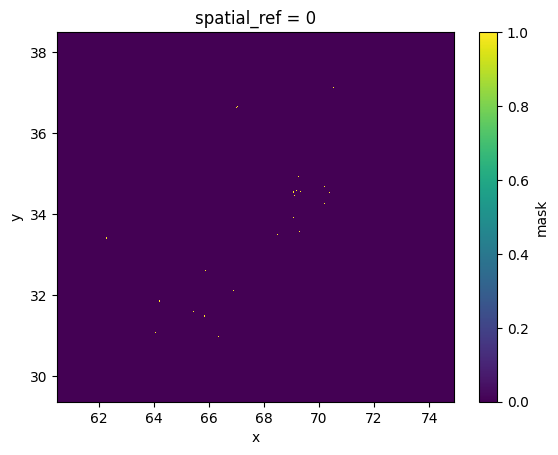

In [58]:
# eye check
# ds_baseALL['OSMmask_bool'].plot()
ds_baseALL['mask'].plot()

# Define the colormap
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('white_red', ['#eeeeee', 'red'])
#ds['std'].plot(cmap=cmap)

NON-BNR DATA: Check Zonal statistics in each military mask

In [59]:
zonal_stats(ds_baseALL['mask'], ds['std'])

# Get the maximum value of the 'std' DataArray
max_std = ds['std'].max().item()

print(max_std)
print(zonal_stats(ds_baseALL['mask'], ds['std']))

71.85500184318389
   zone      mean        max  min           sum        std         var  \
0     0  0.010079  71.855002  0.0  36385.319168   0.279105    0.077899   
1     1  7.649671  66.212383  0.0   9126.057176  11.884466  141.240527   

       count  
0  3609956.0  
1     1193.0  


### Apply the OSM-military polygon filter

For the VIIRS-like data, you must skip this sub-section as it is already OSM-military filtered.

In [60]:
# Apply the OSM filter to avg_rad BNR

# Monthly VIIRS
ds['avg_rad_BNR_OSM'] = ds['avg_rad_BNR'].where(ds_baseALL['OSMmask_bool'])

# VIIRS like data
# ds['avg_rad_BNR_OSM'] = ds['avg_rad'].where(ds_baseALL['OSMmask_bool'])


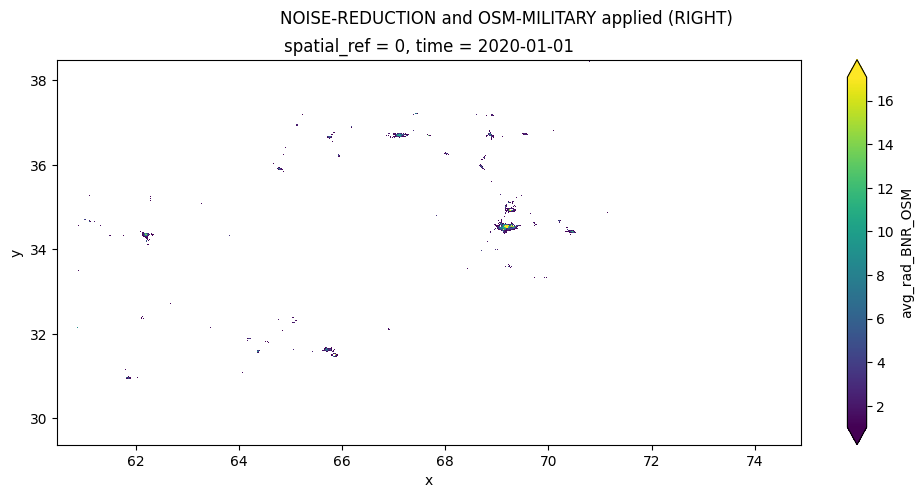

In [61]:
# eye check

fig = plt.figure(figsize = (12, 5))

ax2 = fig.add_subplot(1, 1, 1)
ax2 = ds['avg_rad_BNR_OSM'].sel(time = sample_time).plot(robust = True)


# Add fig title
fig.suptitle("NOISE-REDUCTION and OSM-MILITARY applied (RIGHT)")

plt.show()

# Export fig
#src_fig_temp = os.path.join(fig_loc, 'spatial_visualization_of_OSM_filter_effect.png')
#fig.savefig(src_fig_temp, bbox_inches="tight", dpi=500)

In [ ]:
# Export the raster that the noise-reduced, OSM-military filiter applied if needed (OPTIONAL)

# Want export? 'yes' or 'no'
export_option = 'no'

if export_option == 'yes':

    for y in range(2014, 2024):

        for m in range(1, 13):
          time_temp = str(y) + '-' + str(m).zfill(2) + '-' + '01'
          print(time_temp)

          # Construct a temporary file path
          out_ras_name = os.path.join(data_loc, 'output', 'NRAOSM_afg_viirs_' + str(y) + str(m).zfill(2) + '01' + '.tif')


          # Export an x array
          ds['avg_rad_BNR_OSM'].sel(time = time_temp).rio.to_raster(out_ras_name)

---
# **Apply simple OSM-SDV mask at district level (Product 1)**

### District raster prep

Import an admin border shapefile of interest and rasterize it using a unique ID. The target shapefile must hava one unique ID column.

In [47]:
# Import adm1 vector
# Import Province
#src_adm1 = os.path.join(data_loc, 'adm1_2024', 'adm1_2024.shp')
#gdf_adm1 = tools.vec_import(RW_engine, src_adm1)

#Import District Vector data
src_adm2 = os.path.join(data_loc, 'ADM2_Dist_2024', 'ADM2_Dist_2024.shp')
gdf_adm2 = tools.vec_import(RW_engine, src_adm2)

# Transform the CRS to that of DS
gdf_adm2.to_crs(ds.rio.crs, inplace = True)
gdf_adm2.crs

# Check inside
# gdf_adm1



Vector import complete.
GDF size:401
EPSG:4326


/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
# Specify a unique code for the further processes and check it is really unique

print('No. of districts = {}'.format(len(gdf_adm2)))

#line for Provinces
#print('No. of unique codes = {}'.format(len(gdf_adm1['UNProvCode'].unique())))
#l_ucode_check = sorted(gdf_adm1['UNProvCode'].unique())

#line for districts
print('No. of unique codes = {}'.format(len(gdf_adm2['District24'].unique())))
l_ucode_check = sorted(gdf_adm2['District24'].unique())

print(l_ucode_check)

No. of districts = 401
No. of unique codes = 401
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 201, 202, 203, 204, 205, 206, 207, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 401, 402, 403, 404, 405, 406, 407, 408, 409, 501, 502, 503, 504, 505, 506, 507, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 701, 702, 703, 704, 705, 801, 802, 803, 804, 805, 806, 807, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 150

In [49]:
# Convert to a province geometry list
# province
#geom = gdf_adm1[['geometry', 'UNProvCode']].values.tolist()

# district
geom = gdf_adm2[['geometry', 'District24']].values.tolist()

In [53]:
# Rasterize the province geometry list
# You can select any template variable from DS, which must be 2 dimensional (x, y) without the time dimension.
# Here, we use the 'std' variable, which is a 2 dimensional variable.

r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

xr_temp = ds['std'].copy(deep = True)
xr_temp.data = r_temp

ds_temp = xr_temp.to_dataset()
ds_temp = ds_temp.rename({'std': 'district_id'})

ds_temp

#src_out = os.path.join(data_loc, 'districts.csv')
#ds_temp.to_csv(src_out, index = False)

<xarray.Dataset> Size: 61MB
Dimensions:      (x: 3460, y: 2188)
Coordinates:
  * x            (x) float64 28kB 60.48 60.48 60.49 60.49 ... 74.88 74.89 74.89
  * y            (y) float64 18kB 38.49 38.49 38.48 38.48 ... 29.39 29.38 29.38
    spatial_ref  int64 8B 0
Data variables:
    district_id  (y, x) int64 61MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

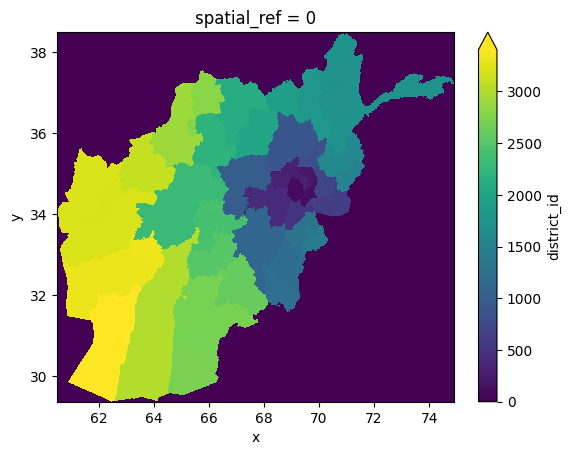

In [54]:
# Visualize the province raster to eye check
ds_temp['district_id'].plot(robust = True)

### Monthly-district level zonal statistics (VIIRS option) --Deprecated--

**Only run Monthly or Yearly, not both**

This method was originally based on the STD (Standard Deviation) and OSM (Open Street Map) datasets, but it has been deprecated in favor of Product 2. Product 1 relies on a fixed time resolution, meaning that any changes to the time resolution can affect the STD values used to detect military bases. For example, the arbitrary value of 8.477, which was set based on data spanning from 2000 to 2022, may no longer be appropriate if the available raster datasets cover a different time range. As a result, using this older method could lead to inaccurate or inconsistent detection due to these changes in temporal data coverage.

In [ ]:
# Province
#df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
#df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)
#vector_id = 'province_id'


# District
df_out = gdf_adm2[['Dist_name', 'District24']].copy()
df_out.rename(columns = {'Dist_name': 'district', 'District24': 'ID'}, inplace = True)
vector_id = 'district_id'


# output is based on date rasters available

for x in list_rasters:
    # Extract the date part from the filename (assuming format like 'afg_viirs_YYYYMM.tif')
    filename = os.path.basename(x)
    file_date_str = filename.split('_')[2].split('.')[0]

    # Extract the year and month
    y = int(file_date_str[:4])  # First 4 characters for the year
    m = int(file_date_str[4:6])  # Last 2 characters for the month

    time_tar = str(y) + '-' + str(m) + '-01'
    time_stamp = str(y) + '-' + str(m)

    print(time_tar)

    # Summary Stats
    df_Zstats_temp = zonal_stats(ds_temp[vector_id], ds['avg_rad_BNR'].sel(time = time_tar))

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

    df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)

    # Within OSM Stats
    df_Zstats_temp = zonal_stats(ds_temp[vector_id], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) ))


    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

    df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)


    df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


    # Within OSM+SDV Stats
    df_Zstats_temp = zonal_stats(ds_temp[vector_id], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

    df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)


    df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100

2023-09-01
2023-10-01
2023-11-01
2023-12-01


### Yearly-district level zonal statistics (VIIRS-like option) --Deprecated--

**Only run Monthly or Yearly, not both**

This method was originally based on the STD (Standard Deviation) and OSM (Open Street Map) datasets, but it has been deprecated in favor of Product 2. Product 1 relies on a fixed time resolution, meaning that any changes to the time resolution can affect the STD values used to detect military bases. For example, the arbitrary value of 8.477, which was set based on data spanning from 2000 to 2022, may no longer be appropriate if the available raster datasets cover a different time range. As a result, using this older method could lead to inaccurate or inconsistent detection due to these changes in temporal data coverage.

In [ ]:
# df_out = gdf_adm1[['Prov_name', 'UNProvCode']].copy()
# df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)

# District
df_out = gdf_adm2[['Dist_name', 'District24']].copy()
df_out.rename(columns = {'Dist_name': 'district', 'District24': 'ID'}, inplace = True)
vector_id = 'district_id'

for x in list_rasters:
      # Extract the date part from the filename (assuming format like 'afg_viirs_YYYYMM.tif')
      filename = os.path.basename(x)
      file_date_str = filename.split('_')[2].split('.')[0]


      # Extract the year and month
      y = int(file_date_str[:4])  # First 4 characters for the year
      m = "01"

      time_tar = str(y) + '-' + str(m) + '-01'
      time_stamp = str(y) + '-' + str(m)

      print(time_tar)

      # Summary Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar))

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

      df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)

      # Within OSM Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) ))


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


      # Within OSM+SDV Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100

### Export Analysis

In [63]:
# Rename the 'ID' colmun to the original unique ID name and review inside:

# Province
#df_out = df_out.rename(columns = {'ID': 'UNProvCode'})


# District
df_out = df_out.rename(columns = {'ID': 'District24'})

df_out

,district,District24,2000-01_mean,2000-01_max,2000-01_min,2000-01_sum,2000-01_std,2000-01_var,2000-01_sum(OSM),2000-01_OSM%,2000-01_sum(OSM+SDV),2000-01_OSM+SDV%,2001-01_mean,2001-01_max,2001-01_min,2001-01_sum,2001-01_std,2001-01_var
0,Qala-ye-Kah,3304,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,Shebkoh,3305,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,Lash-e-Juwayn,3309,0.000037,1.089565,0.0,1.089565,0.006378,0.000041,NaN,NaN,NaN,NaN,0.000037,1.089565,0.0,1.089565,0.006378,0.000041
3,Farah,3301,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,Pushtrod,3302,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,Muqur,3103,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
397,Patoo,2409,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
398,Chenarto,2506,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
399,Hirat,3201,0.251363,10.312821,0.0,333.810307,1.137853,1.294710,NaN,NaN,69.093451,20.698418,0.161333,9.495913,0.0,214.250852,0.818252,0.669536


In [ ]:
# Export the zonal-stats table

out_filename = 'monthly_summary_stats_adm2_2023-09_to_2023-12_v2.csv'
src_out = os.path.join(data_loc, out_filename)
df_out.to_csv(src_out, index = False)

---
## **Apply Walker-verified SDV-based mask at provincial level (Product 2)**

Only available for the VIIRS option.

#### Import the Walker-verified SDV-based mask polygons and rasterize it.

In [64]:
# Import the SDV mask shape
src_aoi = os.path.join(data_loc, 'sdv_mask_verified', 'sdv_mask.shp')
gdf_aoi = tools.vec_import(RW_engine, src_aoi )


# Transform the CRS to that of DS
gdf_aoi.to_crs(ds.rio.crs, inplace = True)
gdf_aoi.crs


# Generate zone ID
gdf_SDV_tar = gdf_aoi.query('priority == 1')
gdf_SDV_tar['zoneID'] = gdf_SDV_tar.index

gdf_SDV_tar#.head(5)

Vector import complete.
GDF size:265
EPSG:4326


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,maskCode,Base,Checked,Erroneous,Discuss,priority,geometry,zoneID
16,SDV1,1,1,0,0,1,"POLYGON ((69.30399 34.58741, 69.30815 34.58741...",16
17,SDV1,1,1,0,0,1,"POLYGON ((69.29565 34.57074, 69.28732 34.57074...",17
18,SDV1,1,1,0,0,1,"POLYGON ((69.19982 34.56241, 69.19149 34.56241...",18
19,SDV1,1,1,0,0,1,"POLYGON ((69.32899 34.55408, 69.32482 34.55408...",19
20,SDV1,1,1,0,0,1,"POLYGON ((69.23732 34.54574, 69.23315 34.54574...",20
22,SDV1,1,1,0,0,1,"POLYGON ((69.26232 34.54158, 69.25815 34.54158...",22
80,SDV2,1,1,0,0,1,"POLYGON ((67.14149 36.69157, 67.13732 36.69157...",80
83,SDV2,1,1,0,0,1,"POLYGON ((67.20816 36.68324, 67.19566 36.68324...",83
85,SDV2,1,1,0,0,1,"POLYGON ((67.12066 36.67907, 67.12899 36.67907...",85
86,SDV2,1,1,0,0,1,"POLYGON ((68.91232 36.67074, 68.89982 36.67074...",86


Import the definition matrix of the opening and closing of bases.

In [68]:
# Import mask definition CSV
df_maskDef = pd.read_csv(os.path.join(data_loc, 'complete_sdv_mask_20240430.csv'))


# Convert the SDV mask values to mask classes
def mask_val_convert(x):

  if x < 0.25:
    x = 0

  elif x < 0.5 :
    x = 2

  else:
    x = 1

  return x


for y in range(2014, 2024):

  tar_col = 'Y' + str(y)
  print(tar_col)
  df_maskDef[tar_col] = df_maskDef[tar_col].apply(lambda x: mask_val_convert(x))


# Check the DF
df_maskDef.head(5)

Y2014
Y2015
Y2016
Y2017
Y2018
Y2019
Y2020
Y2021
Y2022
Y2023


,zoneID,zoneName,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023
0,16,Within Kabul,0,0,1,1,1,1,1,1,0,0
1,17,Within Kabul,2,2,1,1,1,1,1,1,0,0
2,18,Within Kabul,1,1,1,1,1,1,1,2,0,0
3,19,Within Kabul,1,1,1,1,1,1,1,2,0,0
4,20,Within Kabul,1,1,1,1,1,1,1,1,0,0


In [ ]:
# Merge shape and mask definition

df_maskDef_temp = df_maskDef.copy()
gdf_SDV_tar_temp = gdf_SDV_tar[['zoneID', 'geometry']].copy()

gdf_SDV_mask = gdf_SDV_tar_temp.merge(df_maskDef_temp, on = 'zoneID', how = 'inner')

# Add a new column 'Y2024' with all values set to 0 (no current data)
gdf_SDV_mask['Y2024'] = 0


gdf_SDV_mask

In [ ]:
# Remove the 0 values as per Oscar Request this will keep bases open all years
gdf_SDV_mask_no_closing = gdf_SDV_mask.copy(deep=True)
# Columns to process
years = ['Y2014', 'Y2015', 'Y2016', 'Y2017', 'Y2018', 'Y2019', 'Y2020', 'Y2021', 'Y2022', 'Y2023', 'Y2024']

# Function to replace 0s
def replace_zeros(row):

    # Initialize last_value by finding the first non-zero value in the row
    last_value = None
    for year in years:
        if row[year] != 0:
            last_value = row[year]
            break

    # If no non-zero value is found, default to 1
    if last_value is None:
        last_value = 1

    for year in years:
        if row[year] == 0:
            row[year] = last_value
        else:
            last_value = row[year]
    return row

# Apply the function to each row
gdf_SDV_mask_no_closing[years] = gdf_SDV_mask[years].apply(replace_zeros, axis=1)

# Add columns Y2000 to Y2013 with values equal to Y2014
for year in range(2000, 2014):
    col_name = f'Y{year}'
    gdf_SDV_mask_no_closing[col_name] = gdf_SDV_mask_no_closing['Y2014']

# Reorder columns if necessary
all_years = [f'Y{year}' for year in range(2000, 2025)]
gdf_SDV_mask_no_closing = gdf_SDV_mask_no_closing[all_years + [col for col in gdf_SDV_mask_no_closing.columns if col not in all_years]]

gdf_SDV_mask_no_closing

,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,...,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023,Y2024,zoneID,geometry,zoneName
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,16,"POLYGON ((69.30399 34.58741, 69.30815 34.58741...",Within Kabul
1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,17,"POLYGON ((69.29565 34.57074, 69.28732 34.57074...",Within Kabul
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,2,2,2,18,"POLYGON ((69.19982 34.56241, 69.19149 34.56241...",Within Kabul
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,2,2,2,19,"POLYGON ((69.32899 34.55408, 69.32482 34.55408...",Within Kabul
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,20,"POLYGON ((69.23732 34.54574, 69.23315 34.54574...",Within Kabul
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,22,"POLYGON ((69.26232 34.54158, 69.25815 34.54158...",Within Kabul
6,1,1,1,1,1,1,1,1,1,1,...,1,2,1,1,1,1,1,80,"POLYGON ((67.14149 36.69157, 67.13732 36.69157...",In Mazār-e Sharīf
7,1,1,1,1,1,1,1,1,1,1,...,2,1,1,2,2,2,2,83,"POLYGON ((67.20816 36.68324, 67.19566 36.68324...",Camp Marmal
8,2,2,2,2,2,2,2,2,2,2,...,2,2,1,1,1,1,1,85,"POLYGON ((67.12066 36.67907, 67.12899 36.67907...",In Mazār-e Sharīf
9,1,1,1,1,1,1,1,1,1,1,...,1,1,2,2,2,2,2,86,"POLYGON ((68.91232 36.67074, 68.89982 36.67074...",Close to Kundûz


#### Apply the Walker-verified mask and compute the monthly-provincial level zonal statisitcs

##### Version 1 - not apply the Walker-verified mask after 2021 Oct. **--depricated--**

In [ ]:
# # Montly
# l_year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
# #l_year = ['2020']
# l_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


# df_out = gdf_adm2[['Prov_name', 'UNProvCode']].copy()
# df_out.rename(columns = {'Prov_name': 'province', 'UNProvCode': 'ID'}, inplace = True)


# for y in l_year:


#     # Prep a temporary SDV mask raster (by year)
#     year_col = 'Y' + str(y)

#     geom = gdf_SDV_mask[['geometry', year_col]].values.tolist()

#     r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

#     xr_temp = ds['std'].copy(deep = True)
#     xr_temp.data = r_temp

#     ds_SDVmask = xr_temp.to_dataset()
#     ds_SDVmask = ds_SDVmask.rename({'std': 'SDVmask'})

#     # Convert to a DS and boolean array
#     ds_SDVmask['SDVmask_bool'] = ds_SDVmask['SDVmask'] > 0



#     # Check year


#     if int(y) < 2021:

#         for m in l_month:

#             time_tar = y + '-' + m + '-01'
#             time_stamp = y + '-' + m

#             print(time_tar)


#             # Summary Stats
#             df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

#             df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

#             #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
#             df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
#             df_out.drop(columns = ['zone'], inplace = True)



#             # [A] Within SDV-mask Stats (Potentially Coalition bases)
#             df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


#             df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

#             df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

#             df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
#             df_out.drop(columns = ['zone'], inplace = True)


#             df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



#             # [B] Within SDV-mask Stats (Potentially Afghan bases)
#             df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


#             df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

#             df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

#             df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
#             df_out.drop(columns = ['zone'], inplace = True)


#             df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100




#     elif int(y) == 2021:#Special loop for year 2021

#         for m in l_month:

#             if int(m) < 10:

#                 time_tar = y + '-' + m + '-01'
#                 time_stamp = y + '-' + m

#                 print(time_tar)


#                 # Summary Stats
#                 df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

#                 df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

#                 #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
#                 df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
#                 df_out.drop(columns = ['zone'], inplace = True)



#                 # [A] Within SDV-mask Stats (Potentially Coalition bases)
#                 df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


#                 df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

#                 df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

#                 df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
#                 df_out.drop(columns = ['zone'], inplace = True)


#                 df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



#                 # [B] Within SDV-mask Stats (Potentially Afghan bases)
#                 df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


#                 df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

#                 df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

#                 df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
#                 df_out.drop(columns = ['zone'], inplace = True)


#                 df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


#             else:

#                 time_tar = y + '-' + m + '-01'
#                 time_stamp = y + '-' + m

#                 print(time_tar)


#                 # Summary Stats
#                 df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

#                 df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

#                 #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
#                 df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
#                 df_out.drop(columns = ['zone'], inplace = True)



#                 # [A] Within SDV-mask Stats (Potentially Coalition bases) MASK OFF
#                 df_out[time_stamp + '_sum(Coalition)'] = ''
#                 df_out[time_stamp + '_Coalition%'] = ''



#                 # [B] Within SDV-mask Stats (Potentially Afghan bases) MASK OFF
#                 df_out[time_stamp + '_sum(Afghan)'] = ''
#                 df_out[time_stamp + '_Afghan%'] = ''



#     else:#Special loop for year 2022-2023

#         for m in l_month:

#             time_tar = y + '-' + m + '-01'
#             time_stamp = y + '-' + m

#             print(time_tar)


#             # Summary Stats
#             df_Zstats_temp = zonal_stats(ds_temp['province_id'], ds['avg_rad_BNR'].sel(time = time_tar))

#             df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

#             #df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
#             df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
#             df_out.drop(columns = ['zone'], inplace = True)



#             # [A] Within SDV-mask Stats (Potentially Coalition bases) MASK OFF
#             df_out[time_stamp + '_sum(Coalition)'] = ''
#             df_out[time_stamp + '_Coalition%'] = ''



#             # [B] Within SDV-mask Stats (Potentially Afghan bases) MASK OFF
#             df_out[time_stamp + '_sum(Afghan)'] = ''
#             df_out[time_stamp + '_Afghan%'] = ''

##### Version 2 - apply the Walker-verified mask even after 2021 Oct.

In [ ]:
ds_temp

<xarray.Dataset> Size: 15MB
Dimensions:      (x: 3460, y: 2188)
Coordinates:
  * x            (x) float64 28kB 60.48 60.48 60.49 60.49 ... 74.88 74.89 74.89
  * y            (y) float64 18kB 38.49 38.49 38.48 38.48 ... 29.39 29.38 29.38
    spatial_ref  int64 8B 0
Data variables:
    district_id  (y, x) uint16 15MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

### Monthly Analysis

Run this analysis if you are using the monthly viirs rasters

In [ ]:
#district
df_out = gdf_adm2[['Dist_name', 'District24']].copy()
df_out.rename(columns = {'Dist_name': 'district', 'District24': 'ID'}, inplace = True)


#Get statistics for each raster
for x in list_rasters:

    # Extract the date part from the filename (assuming format like 'afg_viirs_YYYYMM.tif')
    filename = os.path.basename(x)
    file_date_str = filename.split('_')[2].split('.')[0]
    y = file_date_str[:4]
    m = file_date_str[4:]

    # Prep a temporary SDV mask raster (by year)
    # Rasterize gdf_SDV_mask
    year_col = 'Y' + str(y)

    geom = gdf_SDV_mask[['geometry', year_col]].values.tolist()

    r_temp = features.rasterize(geom, out_shape = ds['std'].shape, transform = ds.rio.transform())

    xr_temp = ds['std'].copy(deep = True)
    xr_temp.data = r_temp

    ds_SDVmask = xr_temp.to_dataset()
    ds_SDVmask = ds_SDVmask.rename({'std': 'SDVmask'})

    # Convert to a DS and boolean array
    ds_SDVmask['SDVmask_bool'] = ds_SDVmask['SDVmask'] > 0

    # Rasterize gdf_SDV_mask_no_closing
    geom_no_closing = gdf_SDV_mask_no_closing[['geometry', year_col]].values.tolist()
    r_temp_no_closing = features.rasterize(geom_no_closing, out_shape=ds['std'].shape, transform=ds.rio.transform())
    xr_temp_no_closing = ds['std'].copy(deep=True)
    xr_temp_no_closing.data = r_temp_no_closing
    ds_SDVmask_no_closing = xr_temp_no_closing.to_dataset(name='SDVmask_no_closing')
    ds_SDVmask_no_closing['SDVmask_no_closing_bool'] = ds_SDVmask_no_closing['SDVmask_no_closing'] > 0



    # Check year


    #if int(y) < 2024:

        #for m in l_month:

    time_tar = y + '-' + m + '-01'
    time_stamp = y + '-' + m

    print(time_tar)
    #to get province change district_id to province_id and viceversa

    # Summary Stats
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time = time_tar))

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

    df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')#All statistics
    #df_out = df_out.merge(df_Zstats_temp[['zone', time_stamp + '_sum']], left_on = 'ID', right_on = 'zone', how = 'inner')#Only sum
    df_out.drop(columns = ['zone'], inplace = True)


    # Within OSM Stats
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time = time_tar).where((ds_baseALL['mask'] == 1)))


    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

    df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)


    df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


    # # Within OSM+SDV Stats we are not using SDV anymore
    # df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


    # df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    # df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

    # df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    # df_out.drop(columns = ['zone'], inplace = True)


    # df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100


    # [A] Within SDV-mask Stats (Potentially Coalition bases)
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 1) ))


    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Coalition)'})

    df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)


    df_out[time_stamp + '_Coalition%'] = df_out[time_stamp + '_sum(Coalition)'] / df_out[time_stamp + '_sum'] * 100



    # [B] Within SDV-mask Stats (Potentially Afghan bases)
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time = time_tar).where( (ds_SDVmask['SDVmask'] == 2) ))


    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

    df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(Afghan)'})

    df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
    df_out.drop(columns = ['zone'], inplace = True)


    df_out[time_stamp + '_Afghan%'] = df_out[time_stamp + '_sum(Afghan)'] / df_out[time_stamp + '_sum'] * 100


    # [C] Within SDV-mask_no_closing Stats (Potentially Coalition bases)
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time=time_tar).where(ds_SDVmask_no_closing['SDVmask_no_closing'] == 1))
    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]
    df_Zstats_temp = df_Zstats_temp.rename(columns={'sum': time_stamp + '_sum(Coalition_NoClosing)'})
    df_out = df_out.merge(df_Zstats_temp, left_on='ID', right_on='zone', how='inner')
    df_out.drop(columns=['zone'], inplace=True)
    df_out[time_stamp + 'Coalition_NoClosing%'] = df_out[time_stamp + '_sum(Coalition_NoClosing)'] / df_out[time_stamp + '_sum'] * 100


    # [D] Within SDV-mask_no_closing Stats (Potentially Coalition bases)
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time=time_tar).where(ds_SDVmask_no_closing['SDVmask_no_closing'] == 2))
    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]
    df_Zstats_temp = df_Zstats_temp.rename(columns={'sum': time_stamp + '_sum(Afghan_NoClosing)'})
    df_out = df_out.merge(df_Zstats_temp, left_on='ID', right_on='zone', how='inner')
    df_out.drop(columns=['zone'], inplace=True)
    df_out[time_stamp + 'Afghan_NoClosing%'] = df_out[time_stamp + '_sum(Afghan_NoClosing)'] / df_out[time_stamp + '_sum'] * 100


    # [E] OSM + Coaltion + Afghan Mask
    df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad_BNR'].sel(time=time_tar).where((ds_SDVmask_no_closing['SDVmask_no_closing'] == 2) | (ds_SDVmask_no_closing['SDVmask_no_closing'] == 1) | (ds_baseALL['mask'] == 1)))
    df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]
    df_Zstats_temp = df_Zstats_temp.rename(columns={'sum': time_stamp + '_sum(OSM_or_Coalition_or_Afghan_no_closing)'})
    df_out = df_out.merge(df_Zstats_temp, left_on='ID', right_on='zone', how='inner')
    df_out.drop(columns=['zone'], inplace=True)
    df_out[time_stamp + 'OSM_or_Coalition_or_Afghan_no_closing%'] = df_out[time_stamp + '_sum(OSM_or_Coalition_or_Afghan_no_closing)'] / df_out[time_stamp + '_sum'] * 100





### Yearly Analysis

Run this analysis if you are using the yearls viirs like rasters


In [ ]:
# VIIRS like data Yearly
l_year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
l_year = range(2000,2023)
#l_year = ['2014']

#district
df_out = gdf_adm2[['Dist_name', 'District24', 'Prov_name']].copy()
df_out.rename(columns = {'Dist_name': 'province', 'District24': 'ID'}, inplace = True)


for y in l_year:


      time_tar = str(y) + '-01-01'
      time_stamp = str(y)

      year_col = 'Y' + str(y)


      # Rasterize gdf_SDV_mask_no_closing
      geom_no_closing = gdf_SDV_mask_no_closing[['geometry', year_col]].values.tolist()
      r_temp_no_closing = features.rasterize(geom_no_closing, out_shape=ds['std'].shape, transform=ds.rio.transform())
      xr_temp_no_closing = ds['std'].copy(deep=True)
      xr_temp_no_closing.data = r_temp_no_closing
      ds_SDVmask_no_closing = xr_temp_no_closing.to_dataset(name='SDVmask_no_closing')
      ds_SDVmask_no_closing['SDVmask_no_closing_bool'] = ds_SDVmask_no_closing['SDVmask_no_closing'] > 0

      print(time_tar)

      # Summary Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar))

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum', 'mean': time_stamp + '_mean', 'max': time_stamp + '_max', 'min': time_stamp + '_min', 'std': time_stamp + '_std', 'var': time_stamp + '_var'})

      df_out = df_out.merge(df_Zstats_temp.drop(columns = ['count']), left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)

      # Within OSM Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) ))


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM%'] = df_out[time_stamp + '_sum(OSM)'] / df_out[time_stamp + '_sum'] * 100


      # Within OSM+SDV Stats
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time = time_tar).where( (ds_baseALL['mask'] == 1) | (ds['std'] == 8.477) | (ds['std'] > 8.477)) )


      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]

      df_Zstats_temp = df_Zstats_temp.rename(columns = {'sum': time_stamp + '_sum(OSM+SDV)'})

      df_out = df_out.merge(df_Zstats_temp, left_on = 'ID', right_on = 'zone', how = 'inner')
      df_out.drop(columns = ['zone'], inplace = True)


      df_out[time_stamp + '_OSM+SDV%'] = df_out[time_stamp + '_sum(OSM+SDV)'] / df_out[time_stamp + '_sum'] * 100

      # [C] Within SDV-mask_no_closing Stats (Potentially Coalition bases)
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time=time_tar).where(ds_SDVmask_no_closing['SDVmask_no_closing'] == 1))
      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]
      df_Zstats_temp = df_Zstats_temp.rename(columns={'sum': time_stamp + '_sum(Coalition_NoClosing)'})
      df_out = df_out.merge(df_Zstats_temp, left_on='ID', right_on='zone', how='inner')
      df_out.drop(columns=['zone'], inplace=True)
      df_out[time_stamp + 'Coalition_NoClosing%'] = df_out[time_stamp + '_sum(Coalition_NoClosing)'] / df_out[time_stamp + '_sum'] * 100


      # [D] Within SDV-mask_no_closing Stats (Potentially Coalition bases)
      df_Zstats_temp = zonal_stats(ds_temp['district_id'], ds['avg_rad'].sel(time=time_tar).where(ds_SDVmask_no_closing['SDVmask_no_closing'] == 2))
      df_Zstats_temp = df_Zstats_temp[['zone', 'sum']]
      df_Zstats_temp = df_Zstats_temp.rename(columns={'sum': time_stamp + '_sum(Afghan_NoClosing)'})
      df_out = df_out.merge(df_Zstats_temp, left_on='ID', right_on='zone', how='inner')
      df_out.drop(columns=['zone'], inplace=True)
      df_out[time_stamp + 'Afghan_NoClosing%'] = df_out[time_stamp + '_sum(Afghan_NoClosing)'] / df_out[time_stamp + '_sum'] * 100

##### Post process and export the product CSV

In [ ]:
# Rename the 'ID' colmun to the original unique ID name and review inside:
# province
# df_out = df_out.rename(columns = {'ID': 'UNProvCode'})

#district
#df_out = df_out.rename(columns = {'ID': 'UNProvCode'})
#df_out = df_out.rename(columns = {'ID': 'UNProvCode'})
#df_out.columns

Index(['province', 'ID', '2014-01_mean', '2014-01_max', '2014-01_min',
       '2014-01_sum', '2014-01_std', '2014-01_var', '2014-01_sum(OSM)',
       '2014-01_OSM%',
       ...
       '2023-12_sum(OSM+SDV)', '2023-12_OSM+SDV%', '2023-12_sum(Coalition)',
       '2023-12_Coalition%', '2023-12_sum(Afghan)', '2023-12_Afghan%',
       '2023-12_sum(Coalition_NoClosing)', '2023-12Coalition_NoClosing%',
       '2023-12_sum(Afghan_NoClosing)', '2023-12Afghan_NoClosing%'],
      dtype='object', length=2162)

In [ ]:
# Export the zonal-stats table
#province
#src_out = os.path.join(data_loc, 'monthly_summary_stats_adm1_2014-2024_SDVmask_Version_V2_ivo_with_OSM_and_OSMstd.csv')

#district
out_filename = 'monthly_summary_stats_adm2_2014-01-2024-03_OSM+Coalition+AFG_bases.csv'
src_out = os.path.join(data_loc, out_filename)
df_out.to_csv(src_out, index = False)